In [1]:
import pickle
import nltk
import numpy as np
import pandas as pd
import modelmetrics

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, log_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('Data/dacy_sentiment.csv', lineterminator='\n')
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
data['sentiment'] = data['sentiment'].replace(sentiment_map)
data.head(10)

,company,title,body,rating,sentiment,predicted,prob_pos,prob_neu,prob_neg\r
0,UPS,forkert adresse måtte selv hente den det rigti...,"Jeg bestilte nogle Nike sko, hvorefter der sto...",1,-1,neutral,0.011,0.986,0.003
1,UPS,Værste amatør nogensinde,Værste amatør nogensinde. Allerede flere gange...,1,-1,negative,0.002,0.001,0.998
2,UPS,Virkelig tynd kundeservice,Virkelig tynd kundeservice. Kan ikke sende et ...,1,-1,negative,0.022,0.001,0.978
3,PostNord i Danmark,Præcision og hurtig levering,Præcision og hurtig levering,5,1,positive,0.914,0.081,0.004
4,UPS,"😡 UPS, aldrig igen!",Hold da op!Hvad sker der for UPS? Kundeservice...,1,-1,positive,0.798,0.110,0.092
5,PostNord i Danmark,Meget tilfreds 👍👍,Meget tilfreds 👍👍,5,1,positive,0.999,0.000,0.001
6,PostNord i Danmark,Jeg har ikke modtaget pakken og den er…,Jeg har ikke modtaget pakken og den er ikke de...,1,-1,neutral,0.001,0.996,0.003
7,PostNord i Danmark,Hurtig levering,Hurtig levering. Hvad mere kan man forlange,5,1,positive,0.985,0.013,0.002
8,PostNord i Danmark,God og hurtig levering lige til døren,God og hurtig levering lige til døren. Punktli...,5,1,positive,0.997,0.001,0.002
9,FedEx,Jeg har lige vundet en hel palle…,"Jeg har lige vundet en hel palle køkkengrej, t...",1,-1,negative,0.008,0.002,0.990


In [3]:
# splitter dataen til traning og test set 80/20
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Vectorizer tekst dataen
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=1000)
train_vectors = vectorizer.fit_transform(train_data['body'])
test_vectors = vectorizer.transform(test_data['body'])

# Træner en Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(train_vectors, train_data['sentiment'])

# Predicter sentiment for et nyt review
new_review = "Bedste levering, super godt arbejde af postnord, lige til tiden"
new_review_vector = vectorizer.transform([new_review])
predicted_sentiment = clf.predict(new_review_vector)[0]

sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

# Print the predicted sentiment
if predicted_sentiment == 1:
    print("Positive sentiment")
elif predicted_sentiment == 0:
    print("Neutral sentiment")
else:
    print("Negative sentiment")


sentiment
 1    332
-1    250
 0     18
Name: count, dtype: int64
Positive sentiment


In [4]:
y_true = test_data['sentiment']
y_pred = clf.predict(test_vectors)
probs = clf.predict_proba(test_vectors)

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92        52
     Neutral       0.00      0.00      0.00         4
    Positive       0.88      0.94      0.91        64

    accuracy                           0.90       120
   macro avg       0.60      0.62      0.61       120
weighted avg       0.87      0.90      0.88       120



/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [7]:
log_loss_test = log_loss(y_true, probs)
log_loss_test

0.8725588397123107

In [8]:
print('Accuracy:', accuracy_score(y_true, y_pred))

Accuracy: 0.9


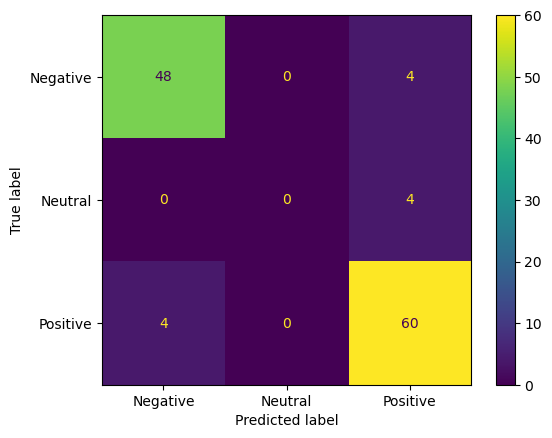

In [9]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Negative', 'Neutral', 'Positive'])

In [7]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # trying to remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove non-alphanumeric characters except "æ, ø, å" and their uppercase counterparts
    text = re.sub(r'[^a-zA-ZæøåÆØÅ\s]', '', text)
    return text.strip()

# Preprocessing  text by removing emojis and non-alphanumeric characters
data['preprocessed_text'] = data['body'].apply(lambda text: preprocess_text(text))

# Lemmatization
lemmatizer = WordNetLemmatizer()
data['lemmatized_texts'] = data['preprocessed_text'].apply(lambda text: [lemmatizer.lemmatize(token) for token in word_tokenize(text)])

# Convert the lemmatized texts back to string representation
data['lemmatized_texts'] = data['lemmatized_texts'].apply(lambda tokens: ' '.join(tokens))


In [8]:
data.head(10)

,company,title,body,rating,sentiment,predicted,prob_pos,prob_neu,prob_neg\r,preprocessed_text,lemmatized_texts
0,UPS,forkert adresse måtte selv hente den det rigti...,"Jeg bestilte nogle Nike sko, hvorefter der sto...",1,-1,neutral,0.011,0.986,0.003,Jeg bestilte nogle Nike sko hvorefter der stod...,Jeg bestilte nogle Nike sko hvorefter der stod...
1,UPS,Værste amatør nogensinde,Værste amatør nogensinde. Allerede flere gange...,1,-1,negative,0.002,0.001,0.998,Vrste amatr nogensinde Allerede flere gange fo...,Vrste amatr nogensinde Allerede flere gange fo...
2,UPS,Virkelig tynd kundeservice,Virkelig tynd kundeservice. Kan ikke sende et ...,1,-1,negative,0.022,0.001,0.978,Virkelig tynd kundeservice Kan ikke sende et s...,Virkelig tynd kundeservice Kan ikke sende et s...
3,PostNord i Danmark,Præcision og hurtig levering,Præcision og hurtig levering,5,1,positive,0.914,0.081,0.004,Prcision og hurtig levering,Prcision og hurtig levering
4,UPS,"😡 UPS, aldrig igen!",Hold da op!Hvad sker der for UPS? Kundeservice...,1,-1,positive,0.798,0.110,0.092,Hold da opHvad sker der for UPS Kundeservice e...,Hold da opHvad sker der for UPS Kundeservice e...
5,PostNord i Danmark,Meget tilfreds 👍👍,Meget tilfreds 👍👍,5,1,positive,0.999,0.000,0.001,Meget tilfreds,Meget tilfreds
6,PostNord i Danmark,Jeg har ikke modtaget pakken og den er…,Jeg har ikke modtaget pakken og den er ikke de...,1,-1,neutral,0.001,0.996,0.003,Jeg har ikke modtaget pakken og den er ikke de...,Jeg har ikke modtaget pakken og den er ikke de...
7,PostNord i Danmark,Hurtig levering,Hurtig levering. Hvad mere kan man forlange,5,1,positive,0.985,0.013,0.002,Hurtig levering Hvad mere kan man forlange,Hurtig levering Hvad mere kan man forlange
8,PostNord i Danmark,God og hurtig levering lige til døren,God og hurtig levering lige til døren. Punktli...,5,1,positive,0.997,0.001,0.002,God og hurtig levering lige til dren Punktlige...,God og hurtig levering lige til dren Punktlige...
9,FedEx,Jeg har lige vundet en hel palle…,"Jeg har lige vundet en hel palle køkkengrej, t...",1,-1,negative,0.008,0.002,0.990,Jeg har lige vundet en hel palle kkkengrej til...,Jeg har lige vundet en hel palle kkkengrej til...


### Wanted to see if it made a difference if the text was cleaned a bit more and compare it to the results above, but right now it removes æ,ø and å. Which it is not suposed to do. It removes emojis tho.

In [9]:
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Load the pre-trained Danish language model
nlp = spacy.load("da_core_news_sm")

# Split the data into training and test sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# Extract named entities from the text data
train_named_entities = train_data['body'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])
test_named_entities = test_data['body'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])

# Convert named entities to text
train_text_with_entities = train_named_entities.apply(lambda entities: ' '.join([entity[0] for entity in entities]))
test_text_with_entities = test_named_entities.apply(lambda entities: ' '.join([entity[0] for entity in entities]))

# Vectorize the text data with named entities
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', max_features=1000)
train_vectors = vectorizer.fit_transform(train_text_with_entities)
test_vectors = vectorizer.transform(test_text_with_entities)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(train_vectors, train_data['sentiment'])

# Predict sentiment for a new review with named entities
new_review = "Bedste levering, super godt arbejde af postnord, lige til tiden"
new_review_entities = [(ent.text, ent.label_) for ent in nlp(new_review).ents]
new_review_text_with_entities = ' '.join([entity[0] for entity in new_review_entities])
new_review_vector = vectorizer.transform([new_review_text_with_entities])
predicted_sentiment = clf.predict(new_review_vector)[0]

# Check sentiment distribution
sentiment_counts = data['sentiment'].value_counts()
print(sentiment_counts)

# Print the predicted sentiment
if predicted_sentiment == 1:
    print("Positive sentiment")
elif predicted_sentiment == 0:
    print("Neutral sentiment")
else:
    print("Negative sentiment")


sentiment
 1    332
-1    250
 0     18
Name: count, dtype: int64
Positive sentiment


In [10]:
y_true = test_data['sentiment']
y_pred = clf.predict(test_vectors)
probs = clf.predict_proba(test_vectors)

report = classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.92      0.44      0.60        52
     Neutral       0.00      0.00      0.00         4
    Positive       0.65      0.97      0.78        64

    accuracy                           0.71       120
   macro avg       0.52      0.47      0.46       120
weighted avg       0.75      0.71      0.67       120



/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/markusagnsgaard/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [11]:
import spacy

# Load the pre-trained Danish language model
nlp = spacy.load('da_core_news_sm')

# Apply NER on the text data
data['entities'] = data['body'].apply(lambda text: [(ent.text, ent.label_) for ent in nlp(text).ents])

# Print the extracted named entities for each text
for index, row in data.iterrows():
    print(f"Text: {row['body']}")
    print("Named Entities:")
    for entity in row['entities']:
        print(f"   - Entity: {entity[0]}, Label: {entity[1]}")
    print()


Virkelig skuffet over UPS og især den fragtmand af en spade!
Named Entities:
   - Entity: UPS, Label: LOC
   - Entity: UPS, Label: LOC

Text: Værste amatør nogensinde. Allerede flere gange forsinket pakke for "fjel i sortering" og også at de levere min pakke i den anden ende af landet til en forkert person.
Named Entities:

Text: Virkelig tynd kundeservice. Kan ikke sende et simpelt spørgsmål uden at lave profil, log-in og hoppe på et ben. Useriøs service.
Named Entities:

Text: Præcision og hurtig levering
Named Entities:

Text: Hold da op!Hvad sker der for UPS? Kundeservice er et ord i ikke burde have lov til at bruge.Jeg købte en vare som jeg betalte i euro og derfor troede kom fra EU, det viste sig at den faktisk kom fra England og import moms og behandlings gebyr, løb op til næsten det samme som varen.Jeg ringede til UPS, hvor en flink dame anbefalede mig, at hun fra UPS bare kunne sende den tilbage, til firmaet fir mig, hvilket var pænt af hende.Jeg spurgte om hun kunne bekræfte 